In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [52]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.75 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [53]:
preprocessor.dates_train

434    5844
440    5844
6        92
184    2557
78     1188
       ... 
27      365
407    5479
230    3106
260    3562
378    5113
Name: date, Length: 391, dtype: int64

In [60]:
data, all_gdps, all_gts = load_data()

print(f"Data shape: {data.shape}")


preprocessor = Preprocessing(data=data, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=True)

X_train[preprocessor.country_train == "Switzerland"].head()

Data shape: (550, 97)


AttributeError: 'int' object has no attribute 'month'

## Simple Prediction Model

### We start with a simple regression model

In [62]:
x = np.array([1,23,4,5,6,787])
len(x), x[:3], x[3:]

(6, array([ 1, 23,  4]), array([  5,   6, 787]))

In [ ]:
x_train = X_train.values
x_valid = X_valid.values
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 100),
            nn.LayerNorm(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.LayerNorm(20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=1000, learning_rate=1e-3, weight_decay=1e-4):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    
    for t in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, training_loss, validation_loss

In [ ]:
model, training_loss, validation_loss = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=100, learning_rate=1e-3, weight_decay=1e-2)

  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss: 0.9481380581855774


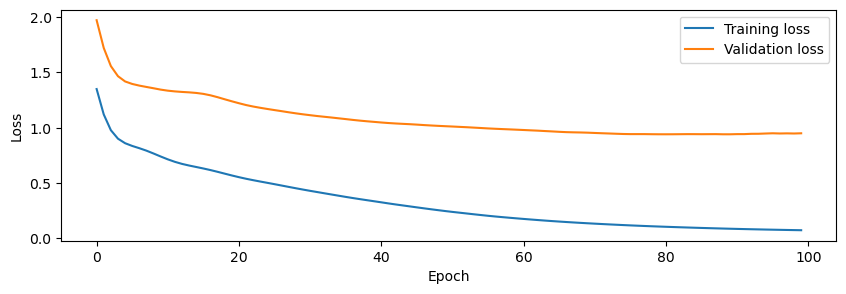

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [ ]:
preprocessor.dates_train.shape, x_train.shape

((394,), torch.Size([391, 104]))

In [ ]:
preprocessor.dates_valid.shape, x_valid.shape, y_valid.shape, preprocessor.country_valid.shape

((129,), torch.Size([131, 104]), (131,), (131,))

In [ ]:
# Associate the result by country
y_pred_country = pd.DataFrame({'date': preprocessor.dates_valid, 'country': country_valid, 'y_pred': y_pred, 'y_true': y_valid})
y_pred_train_country = pd.DataFrame({'date': preprocessor.dates_train, 'country': country_train, 'y_pred': y_pred_train, 'y_true': y_train})
y_pred_train_country

ValueError: array length 131 does not match index length 129

In [ ]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('United Kingdom', 'Japan', 'Korea', 'United St…